In [36]:
import random
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

start_date = '2023-01-01'
end_date = '2023-12-31'
num_rics = 50
mean_return = 0.0005
std_dev_return = 0.01
dates = pd.date_range(start=start_date, end=end_date, freq='B')
universe = [f'RIC_{{{i+1}}}' for i in range(num_rics)]
dummy_returns = np.random.normal(loc=mean_return, scale=std_dev_return, size=(len(dates), num_rics))
df_returns = pd.DataFrame(dummy_returns, index=dates, columns=universe)
cumulative_growth_factor = (1 + df_returns).cumprod()
df_prices = np.random.randint(low=10, high=100, size=num_rics, dtype=int) * cumulative_growth_factor
day1_prices = df_prices[df_prices.index==df_prices.index.min()].to_numpy().flatten()
basket_returns = np.random.normal(loc=mean_return, scale=std_dev_return, size=len(dates))
basket_prices = np.random.randint(low=10, high=100, size=1, dtype=int) * (1 + basket_returns).cumprod()
strikes = np.random.randint(low=10, high=50, size=num_rics, dtype=int)/100

basket_day1_notional = 1000000
basket_shares = basket_day1_notional / basket_prices[0]

FT = np.array(pd.DataFrame(df_returns.to_numpy()).fillna(0))

max_wtiv = 0.9
min_wtiv = 0.1

shorts_multiplier = -1
weight_longs = [0.05, 0.8]
weight_shorts = [0, 1]


price_matrix = df_prices.values  # 252 x 50
return_matrix = df_returns.values  # 252 x 50

# For buy-and-hold, daily dollar returns = shares[i] * price[t-1,i] * return[t,i]
lagged_prices = np.vstack([day1_prices.reshape(1, -1), price_matrix[:-1]])  # 252 x 50
dollar_return_factors = return_matrix * lagged_prices  # 252 x 50 (element-wise)

# Now covariance matrix for dollar returns based on shares
Q_dollar = dollar_return_factors.T @ dollar_return_factors / len(dates)

# Basket dollar returns - basket_prices is already a numpy array
basket_lagged_prices = np.concatenate([[basket_prices[0]], basket_prices[:-1]])  # 252 elements
basket_dollar_returns = basket_shares * basket_lagged_prices * basket_returns  # 252 elements

c_dollar = -2 * (dollar_return_factors.T @ basket_dollar_returns) / len(dates)


opti_res = []

try:
    with open("shawn_results.html", "w") as out:
        shares = cp.Variable(len(universe))

        # x is the Day 1 weight - derived expression
        x = cp.multiply(shares, day1_prices) / basket_day1_notional

        # Decompose x into positive and negative parts
        pos_x = cp.Variable(len(universe), nonneg=True)
        neg_x = cp.Variable(len(universe), nonneg=True)

        pos_selection = cp.Variable(len(universe), boolean=True)
        neg_selection = cp.Variable(len(universe), boolean=True)

        # set bounds on weights
        weight_cons = []
        numMax_longs = math.floor(1/weight_longs[0]) if weight_longs[1]!=0 else len(universe)
        weight_cons += [cp.sum(pos_selection) <= numMax_longs,
                        pos_x <= weight_longs[1]*pos_selection]
        numMax_shorts = math.floor(1/weight_shorts[0]) if weight_shorts[0]!=0 else len(universe)
        weight_cons += [cp.sum(neg_selection) <= numMax_shorts,
                        neg_x <= weight_shorts[1]*neg_selection*-shorts_multiplier]
        weight_cons += [pos_x >= weight_longs[0]*pos_selection,
                        neg_x >= weight_shorts[0]*neg_selection*-shorts_multiplier]

        cons = [
            x == pos_x - neg_x,
            shares @ day1_prices == basket_day1_notional,
            cp.sum(neg_x) <= -shorts_multiplier,
            np.array(strikes) @ x <= max_wtiv,
            np.array(strikes) @ x >= min_wtiv,
        ] + weight_cons

        '''
        Save and display results if optimal solution found.'''
        objective = cp.Minimize(cp.quad_form(shares, Q_dollar) + c_dollar @ shares)
        problem = cp.Problem(objective, cons)
        try:
            problem.solve(solver=cp.SCIP, gp=False, scip_params={
              "limits/gap": 0.05,          # 1% optimality gap acceptable
              "parallel/maxnthreads": 4,   # Use 4 cores
          })
        except Exception as e:
            print(f'Error: {e}')
        if problem.status=='infeasible':
            print('Infeasible.')
        else:
            iter_id = '{}{}{}'.format(str(int(max_wtiv*10000)), str(int(weight_shorts[1]*10000)), str(int(weight_longs[1]*10000)))
            wts = x.value
            indices_x = [i for i in range(len(wts)) if abs(wts[i])>=0.0005]
            assets_x = np.array([universe[i] for i in indices_x])
            weights_x = np.array([wts[i] for i in indices_x])
            strikes_x = np.array([round(strikes[i],4) for i in indices_x])
            sorted_i = list(reversed(np.argsort(weights_x)))
            print(np.around(wts,4))
except KeyboardInterrupt:
    raise KeyboardInterrupt


[ 0.      0.13    0.0657  0.0968  0.      0.     -0.0152 -0.079   0.
  0.     -0.044   0.     -0.0527  0.     -0.0945  0.0962  0.1126  0.0988
  0.0981  0.1062  0.0956  0.      0.1754 -0.0547  0.      0.093   0.
  0.1174  0.068   0.     -0.1614 -0.0575 -0.0453 -0.0801 -0.0378 -0.0736
  0.      0.0844  0.0869  0.0653 -0.046   0.      0.0737  0.1256  0.
 -0.0646  0.1194  0.0906 -0.0937  0.    ]


/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [37]:
sum([w for w in wts if w>0])

np.float64(2.0000002100076575)

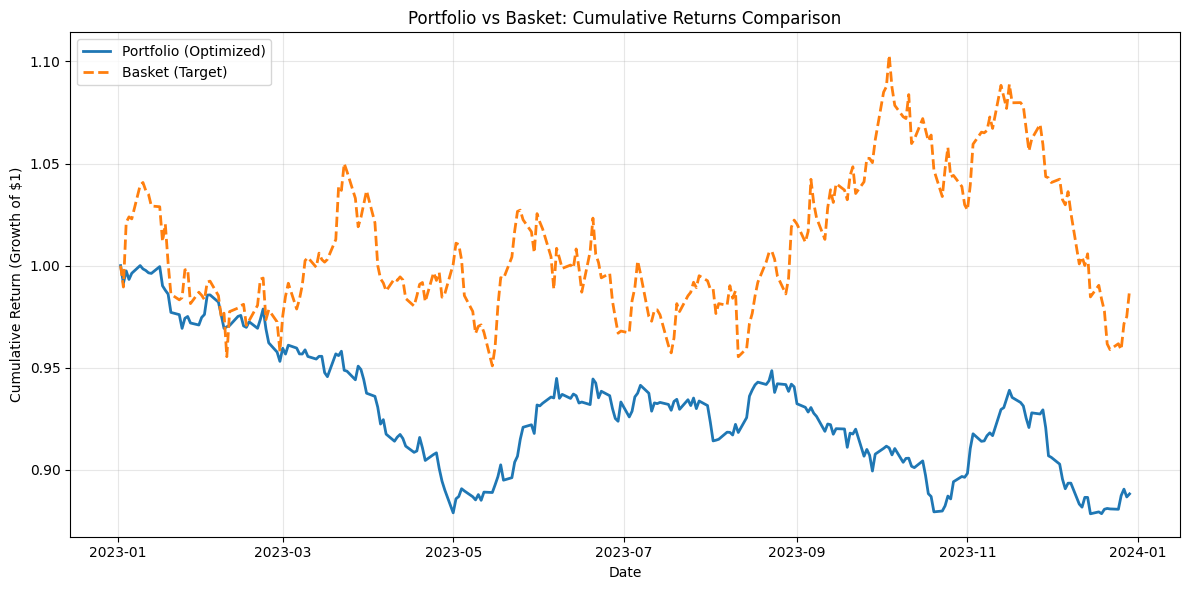


=== Performance Summary ===
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $888,183.13
Portfolio Total Return: -11.18%

Initial Basket Value: $1,000,000.00
Final Basket Value: $987,946.65
Basket Total Return: -1.21%

Tracking Error (Std Dev): $47,957.40
Final Tracking Difference: $-99,763.52
Correlation: 0.4489


In [40]:
if problem.status == 'optimal' or problem.status == 'optimal_inaccurate':
    # Get optimal shares
    optimal_shares = shares.value

    # Calculate portfolio dollar values over time (buy-and-hold)
    # Portfolio value on day t = sum(shares[i] * price[t, i])
    portfolio_values = df_prices.values @ optimal_shares  # 252 x 1

    # Calculate basket dollar values over time
    basket_values = basket_shares * basket_prices.flatten()  # 252 x 1

    # Calculate daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    basket_returns_actual = np.diff(basket_values) / basket_values[:-1]

    # Calculate cumulative returns (growth of $1)
    portfolio_cumulative = np.cumprod(1 + portfolio_returns)
    basket_cumulative = np.cumprod(1 + basket_returns_actual)

    # Add initial value of 1.0 at the start
    portfolio_cumulative = np.concatenate([[1.0], portfolio_cumulative])
    basket_cumulative = np.concatenate([[1.0], basket_cumulative])

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(dates, portfolio_cumulative, label='Portfolio (Optimized)', linewidth=2)
    plt.plot(dates, basket_cumulative, label='Basket (Target)', linewidth=2, linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Growth of $1)')
    plt.title('Portfolio vs Basket: Cumulative Returns Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate tracking statistics
    tracking_diff = portfolio_values - basket_values
    tracking_error = np.std(tracking_diff)
    final_portfolio_value = portfolio_values[-1]
    final_basket_value = basket_values[-1]

    print(f"\n=== Performance Summary ===")
    print(f"Initial Portfolio Value: ${portfolio_values[0]:,.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
    print(f"Portfolio Total Return: {(final_portfolio_value/portfolio_values[0] - 1)*100:.2f}%")
    print(f"\nInitial Basket Value: ${basket_values[0]:,.2f}")
    print(f"Final Basket Value: ${final_basket_value:,.2f}")
    print(f"Basket Total Return: {(final_basket_value/basket_values[0] - 1)*100:.2f}%")
    print(f"\nTracking Error (Std Dev): ${tracking_error:,.2f}")
    print(f"Final Tracking Difference: ${tracking_diff[-1]:,.2f}")

    # Correlation
    corr = np.corrcoef(portfolio_returns, basket_returns_actual)[0, 1]
    print(f"Correlation: {corr:.4f}")

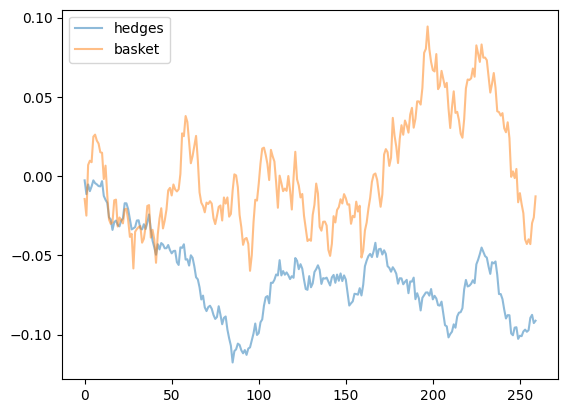

In [41]:
plt.plot(np.cumsum(FT@wts), alpha=0.5, label='hedges')
plt.plot(np.cumsum(basket_returns), alpha=0.5, label='basket')
plt.legend()

In [42]:
df_returns.values

array([[ 0.00355134,  0.01098839,  0.00016105, ..., -0.00929116,
         0.00112183,  0.0106921 ],
       [ 0.01059309, -0.01292324, -0.01953703, ..., -0.00402769,
         0.01343275, -0.00342622],
       [-0.01139386, -0.01103904, -0.02115829, ...,  0.01053218,
        -0.00380439,  0.00418669],
       ...,
       [-0.01547121, -0.0009582 , -0.01065429, ..., -0.00428504,
        -0.01452229, -0.00734552],
       [-0.01356676, -0.0106362 , -0.00276952, ..., -0.00435245,
        -0.00794117, -0.00607254],
       [ 0.00411331,  0.00319657, -0.02660562, ...,  0.0005675 ,
         0.00641797, -0.00228679]])